# Example 02. Generate a single scan PAVD profile

This example generates a single scan Plant Area Volume Density (PAVD) profile using Jupp et al. (2009).
The robust plane fitting approach of Calders et al. (2014) is used for defining the ground and height above ground.

## Load all the required modules

In [1]:
import os
import numpy as np

import matplotlib.pyplot as plt

from riegl_canopy import riegl_io, plant_profile

## Some plotting functions

In [2]:
def plot_ground_plane(x, y, z, grid_extent, grid_resolution, planefit):
    """Example function to plot a ground plane"""
    
    xv = yv = np.linspace(-grid_extent/2, grid_extent/2, grid_extent//grid_resolution + 1)
    xc,yc = np.meshgrid(xv,yv)
    zc = planefit['Parameters'][1] * xc + planefit['Parameters'][2] * yc + planefit['Parameters'][0]
    
    fig = plt.figure(figsize=[8,8])
    fig.tight_layout()
    with plt.style.context('seaborn-talk'):
        ax = fig.add_subplot(projection='3d')
        ax.plot_wireframe(xc, yc, zc)
        ax.scatter(x, y, z, color='Brown')
        ax.set(xlabel='X', ylabel='Y', zlabel='Z')
        ax.set(title=f'Extent = {grid_extent}m | Resolution = {grid_resolution}m')
        
    plt.show()
    
    
def plot_vertical_profiles(profiles, height, labels=['Hinge','Linear','Weighted'], title=None,
                          figsize=[6,6], ylim=(0,50), xlim=None, xlabel=r'PAVD ($m^2 m^{-3}$)'):
    """Example function to plot a vertical profile"""
    fig, ax = plt.subplots(figsize=figsize, squeeze=True)
    with plt.style.context('seaborn-talk'):
        for i,profile in enumerate(profiles):
            if labels is None:
                ax.plot(profile, height, linewidth=1.5)
            else:
                ax.plot(profile, height, label=labels[i], linewidth=1.5)
        ax.set(xlabel=xlabel, ylabel='Height (m)')
        ax.set(ylim=ylim, xlim=xlim, title=title)
        ax.set_facecolor('white')
        if labels is not None:
            ax.legend()
    fig.tight_layout() 
    plt.show()

## Identify all of the input files

In [3]:
os.chdir('/gpfs/data1/vclgp/armstonj/tls_temp/2021-07-18.003.RiSCAN')

rxp_fn = 'SCANS/ScanPos001/SINGLESCANS/210718_115347.rxp'
rdbx_fn = 'project.rdb/SCANS/ScanPos001/SINGLESCANS/210718_115347/210718_115347.rdbx'
transform_fn = 'ScanPos001.DAT'

## Fit and check the ground plane

In [4]:
grid_extent = 60
grid_resolution = 10
x,y,z,r = plant_profile.get_min_z_grid([rdbx_fn], [transform_fn], grid_extent, grid_resolution)

In [5]:
# Optional weighting of points by 1 / range
planefit = plant_profile.plane_fit_hubers(x, y, z, w=1/r)
planefit['Summary']

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                      Z   No. Observations:                   49
Model:                            RLM   Df Residuals:                       46
Method:                          IRLS   Df Model:                            2
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Fri, 25 Nov 2022                                         
Time:                        00:37:49                                         
No. Iterations:                    10                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.4606      0.004   -356.443      0.000      -1.469      -1.453
X              0.0059      0.000     15.147      0.000       0.005       0.007
Y             -0.0028      0.000     -6.850      0.000      -0.004      -0.002
==============================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

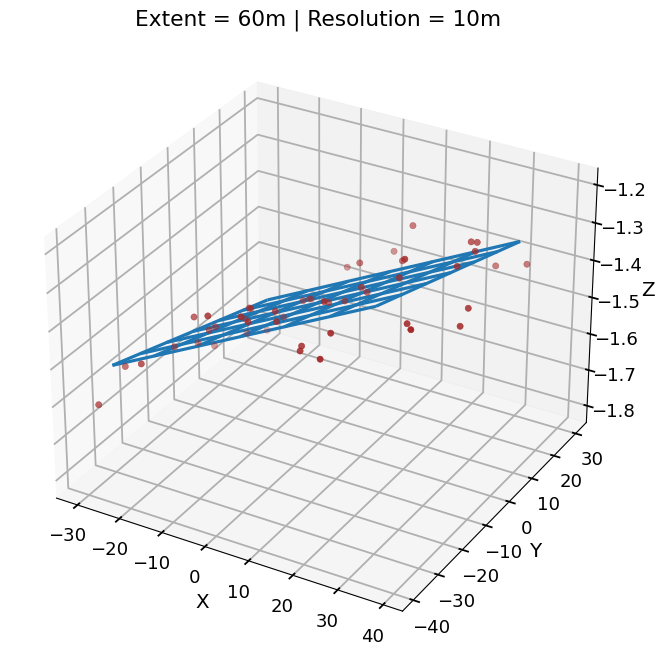

In [6]:
plot_ground_plane(x, y, z, grid_extent, grid_resolution, planefit)

## Generate the vertical plant profile

In [7]:
vpp = plant_profile.Jupp2009(hres=0.5, zres=5, ares=90, min_z=35, max_z=70, min_h=0, max_h=50)

In [8]:
vpp.add_scan_position(rdbx_fn, rxp_fn, transform_fn, planefit,
    method='WEIGHTED', min_zenith=35, max_zenith=70)

### Compute Pgap by zenith bin

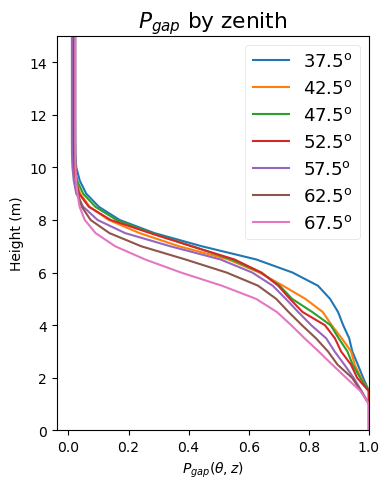

In [9]:
vpp.get_pgap_theta_z(min_azimuth=0, max_azimuth=360)

pgap_labels = [fr'{b:.1f}$\rm ^o$' for b in vpp.zenith_bin]
plot_vertical_profiles(vpp.pgap_theta_z, vpp.height_bin, xlabel=r'$P_{gap}(\theta,z)$',
                      labels=pgap_labels, ylim=[0,15], xlim=[None,1], figsize=[4,5], 
                      title=r'$P_{gap}$ by zenith')

### Compute Pgap by azimuth bin

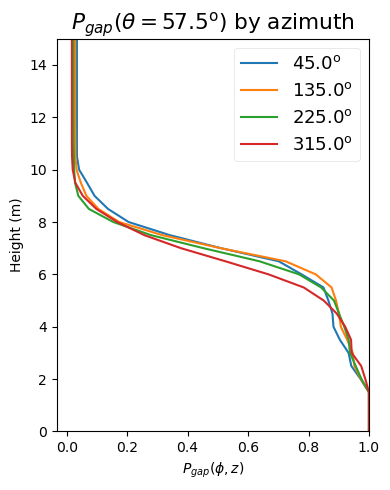

In [10]:
hinge_idx = np.argmin(abs(vpp.azimuth_bin - 57.5))
pgap_phi_z = []
for az in range(0, 360, vpp.ares):
    vpp.get_pgap_theta_z(min_azimuth=az, max_azimuth=az+vpp.ares)
    pgap_phi_z.append(vpp.pgap_theta_z[hinge_idx])

pgap_labels = [fr'{b:.1f}$\rm ^o$' for b in vpp.azimuth_bin]
plot_vertical_profiles(pgap_phi_z, vpp.height_bin, xlabel=r'$P_{gap}(\phi,z)$',
                      labels=pgap_labels, ylim=[0,15], xlim=[None,1], figsize=[4,5],
                      title=r'$P_{gap}$($\theta=57.5\rm ^o$) by azimuth')

### Compute vertical plant profiles

In [11]:
vpp.get_pgap_theta_z(min_azimuth=0, max_azimuth=360)

hinge_pai = vpp.calcHingePlantProfiles()
weighted_pai = vpp.calcSolidAnglePlantProfiles()
linear_pai,linear_mla = vpp.calcLinearPlantProfiles()

hinge_pavd = vpp.get_pavd(hinge_pai)
linear_pavd = vpp.get_pavd(linear_pai)
weighted_pavd = vpp.get_pavd(weighted_pai)

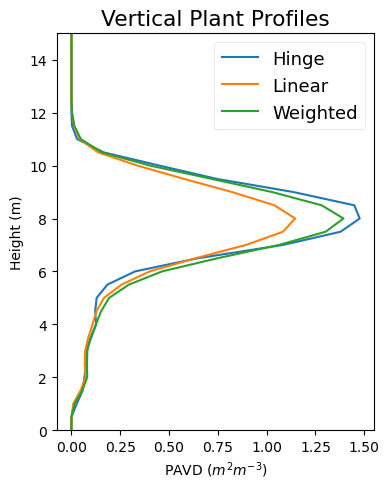

In [12]:
plot_vertical_profiles([hinge_pavd,linear_pavd,weighted_pavd], vpp.height_bin, 
                       labels=['Hinge','Linear','Weighted'], ylim=[0,15], figsize=[4,5],
                       title='Vertical Plant Profiles')